In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
from tqdm import tqdm

# Visualization
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from lightgbm import plot_tree,plot_metric

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler, PowerTransformer, QuantileTransformer, OrdinalEncoder, LabelEncoder, OneHotEncoder

# Model Selection
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, cross_val_predict, RepeatedKFold

# Models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, log_evaluation, early_stopping
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier

# Metrics
from sklearn.metrics import log_loss, accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('Data.csv')
df

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7900,7900,1166,D-penicillamine,16839,F,N,N,N,N,0.8,309.0,3.56,38.0,1629.0,79.05,224.0,344.0,9.9,2.0,C
7901,7901,1492,Placebo,17031,F,N,Y,N,N,0.9,260.0,3.43,62.0,1440.0,142.00,78.0,277.0,10.0,4.0,C
7902,7902,1576,D-penicillamine,25873,F,N,N,Y,S,2.0,225.0,3.19,51.0,933.0,69.75,62.0,200.0,12.7,2.0,D
7903,7903,3584,D-penicillamine,22960,M,N,Y,N,N,0.7,248.0,2.75,32.0,1003.0,57.35,118.0,221.0,10.6,4.0,D


In [ ]:
df.drop(['id'], inplace=True, axis=1)

# EDA

In [ ]:
target = 'Status'

full_features = df.columns.tolist()
num_var = [column for column in df.columns if df[column].nunique() > 10 and column != target]
cat_var = [column for column in df.columns if df[column].nunique() < 10 and column != target]

In [ ]:
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    return summ

In [ ]:
summary(df).style.background_gradient(cmap='Blues')


data shape: (7905, 19)


,data type,#missing,%missing,#unique,min,max
N_Days,int64,0,0.000000,461,41.000000,4795.000000
Drug,object,0,0.000000,2,nan,nan
Age,int64,0,0.000000,391,9598.000000,28650.000000
Sex,object,0,0.000000,2,nan,nan
Ascites,object,0,0.000000,2,nan,nan
Hepatomegaly,object,0,0.000000,2,nan,nan
Spiders,object,0,0.000000,2,nan,nan
Edema,object,0,0.000000,3,nan,nan
Bilirubin,float64,0,0.000000,111,0.300000,28.000000
Cholesterol,float64,0,0.000000,226,120.000000,1775.000000


**Observation:**

According to the introduction of the competition, the data is interpreted as follows:

Feature Explanation

* N_Days:Number of days between registration and the earlier of death, transplantation, or study analysis time in July 1986.
Status:Patient status: C (censored), CL (censored due to liver tx), or D (death).
* Drug:Type of drug administered, either D-penicillamine or placebo.
* Age:Age of the patient in days.
* Sex:Gender of the patient, either male (M) or female (F).
* Ascites:Presence of ascites: N (No) or Y (Yes).
* Hepatomegaly:Presence of hepatomegaly: N (No) or Y (Yes).
* Spiders:Presence of spider angiomas: N (No) or Y (Yes).
* Edema:Presence of edema: N (No edema and no diuretic therapy), S (edema present without diuretics, or resolved by diuretics), or Y (edema despite diuretic therapy).
* Bilirubin:Serum bilirubin concentration in mg/dl.
* Cholesterol:Serum cholesterol concentration in mg/dl.
* Albumin:Albumin concentration in gm/dl.
* Copper:Urine copper amount in ug/day.
* Alk_Phos:Alkaline phosphatase concentration in U/liter.
* SGOT:Serum glutamic oxaloacetic transaminase (SGOT) concentration in U/ml.
* Triglycerides:Triglycerides concentration in mg/dl.
* Platelets:Platelet count per cubic ml/1000.
* Prothrombin:Prothrombin time in seconds (s).
* Stage:Histologic stage of disease: 1, 2, 3, or 4.

## Correlation

In [ ]:
def correlation_plot(data, vars):
    corr = data[vars].corr()
    # mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(11, 9))
    sns.heatmap(corr, annot=True, cmap='Blues', fmt='.2f', linewidths=1,
                square=True, annot_kws={"size": 9}, cbar = False)
    plt.suptitle('Correlation Matrices',
                fontsize=25, weight = 'bold')
    plt.show()

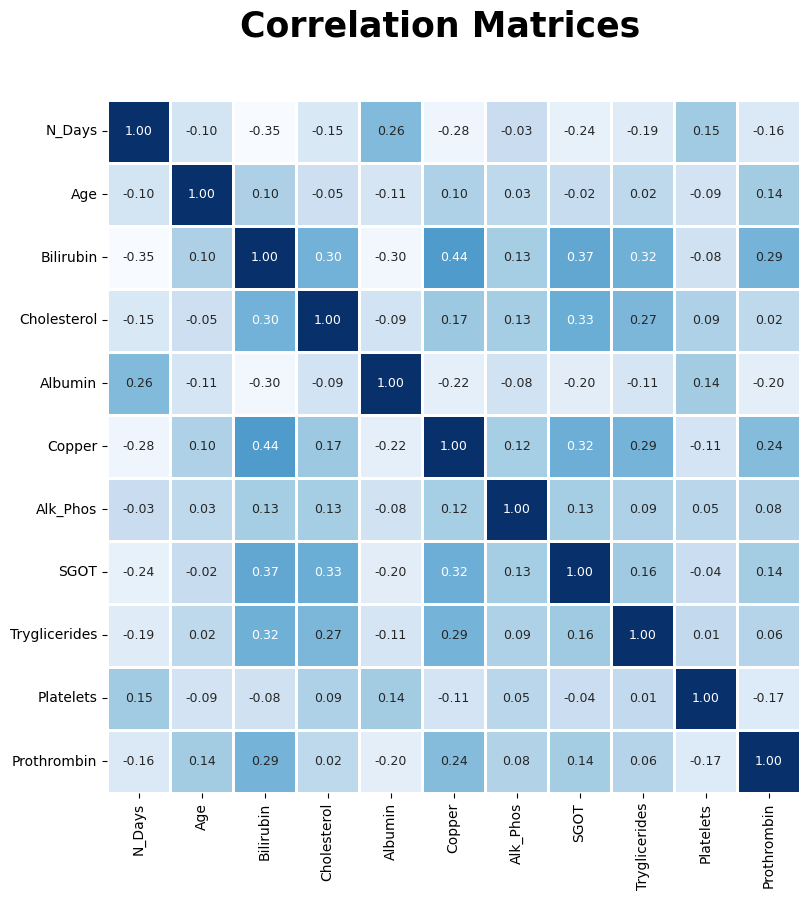

In [ ]:
correlation_plot(df, num_var)


**Observation:**

The majority of variables do not exhibit significant linear correlations. The highest correlation coefficient does not even exceed 0.5.

## CrossTab


In [ ]:
def crosstab_plot(data_set=None, num_var=None, target=None):
    if data_set is None or num_var is None or target is None:
        raise ValueError("Please provide data_set, num_var, and target.")

    num_rows = len(num_var)
    num_cols = 3

    total_plots = num_rows * num_cols
    plt.figure(figsize=(14, num_rows * 4))

    for idx, col in enumerate(num_var):
        plt.subplot(num_rows, num_cols, idx % total_plots + 1)
        sns.heatmap(data=pd.crosstab(data_set[col], data_set[target], normalize = 'index'), annot=True, fmt='.2f', cmap=sns.color_palette("Blues", as_cmap=True))
        plt.title(f"{col} vs {target}")

    plt.tight_layout()
    plt.show()

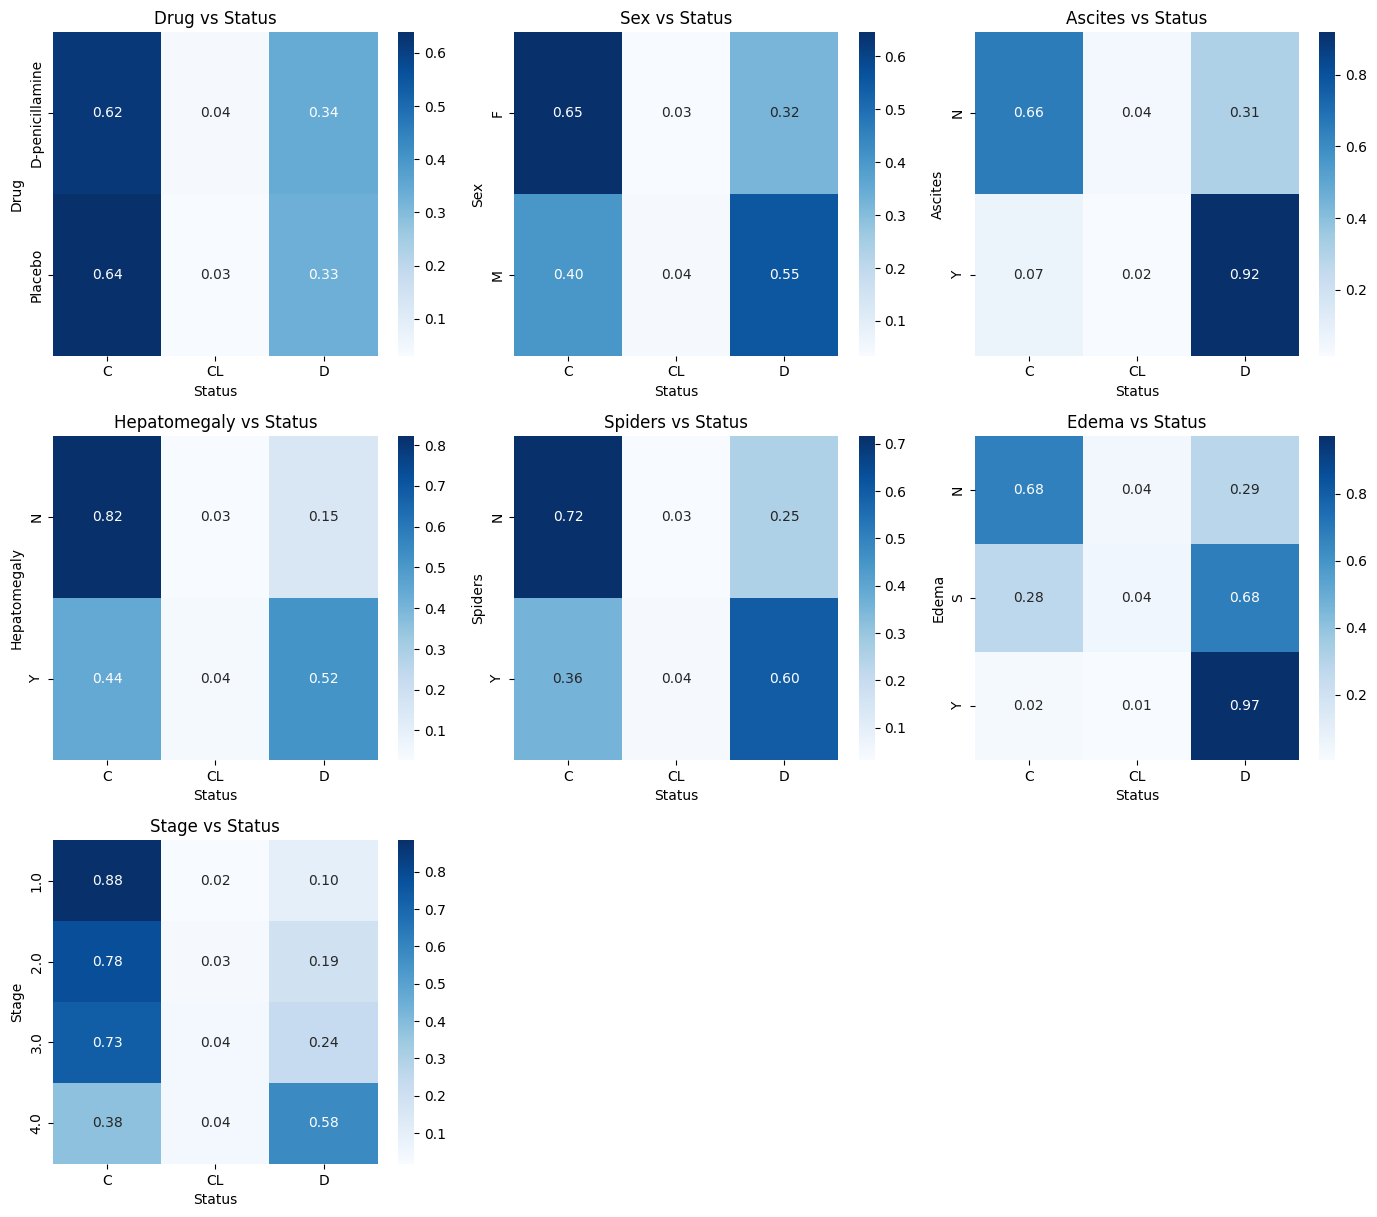

In [ ]:
crosstab_plot(data_set=df, num_var=cat_var, target=target)


**Observation:**

* CL always has the smallest percentage.
* When Ascites is Yes, there is a 92% probability that the Status is D.
* Females are more likely to have Status C compared to males.
* When Hepatomegaly is No, there is a 92% probability that the Status is C.
* When Edema is Yes, there is a 97% probability that the Status is D.
* When Drug changes, it seems not to have a significant impact on Status.

## Boxplot between Target and Numeric Variables


In [ ]:
def scatter_box_plot(data_set = None, variables = None, target = None):
    if data_set is None or variables is None or target is None:
        raise ValueError("Please provide data_set, variables, and target.")

    num_rows = len(variables)
    num_cols = 3
    total_plots = num_rows * num_cols
    plt.figure(figsize=(14, num_rows * 4))

    for idx, col in enumerate(variables):
        plt.subplot(num_rows, num_cols, idx % total_plots + 1)
        sns.boxplot(x=target, y=col, data=data_set, color='#82B0D2',hue=target)
        plt.title(f"{col} vs {target}")

    plt.tight_layout()
    plt.show()

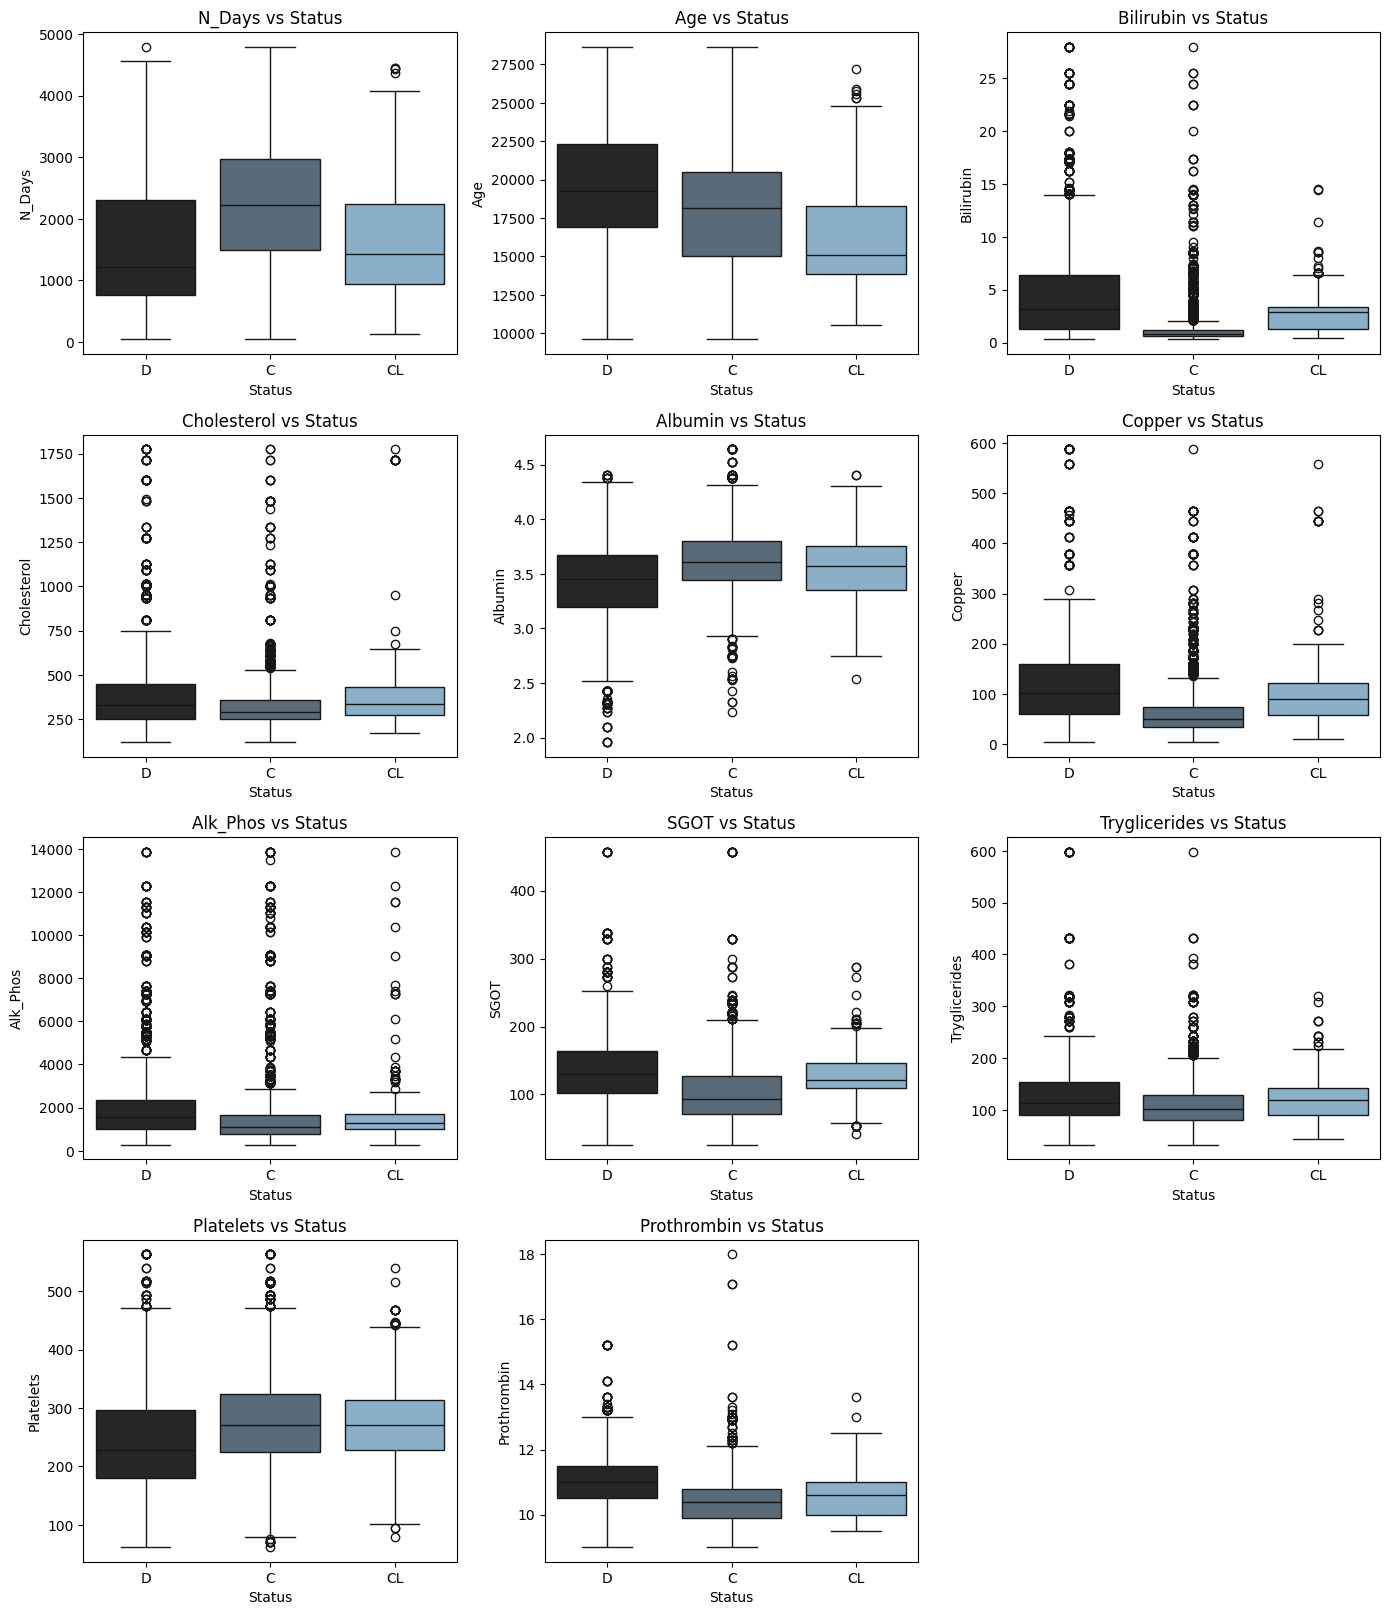

In [ ]:
scatter_box_plot(data_set=df, variables=num_var, target=target)

**Observations:**
* Higher in D:

Bilirubin, Copper, Alk_Phos, SGOT, Prothrombin → Indicate liver damage and poor prognosis.

Age and N_Days also higher in D.

* Lower in D:

Albumin and Platelets → Indicators of better liver function and clotting in CL.

* CL Group:

Generally healthier profiles with better liver markers and lower age.

**Distribution of Numeric Variables**

In [ ]:
def distribution_box_plot(data_set=None, variables=None, target=None):
    if data_set is None or variables is None:
        raise ValueError("Please provide data_set and variables.")

    fig, axes = plt.subplots(len(variables), 2, figsize=(16, len(variables) * 4.2),
                             gridspec_kw={'hspace': 0.35, 'wspace': 0.3, 'width_ratios': [0.80, 0.20]})
    for i, col in enumerate(variables):
        ax = axes[i, 0]
        sns.histplot(data=data_set, hue=target,x=col, bins=30, kde=True, ax=ax, linewidth=2.1, color='lightblue')
        ax.set_title(f"\n{col}", fontsize=15, fontweight='bold')
        ax.grid(visible=True, which='both', linestyle='--', linewidth=0.75)

        ax = axes[i, 1]
        sns.boxplot(x=target, data=data_set, y=col, width=0.25, saturation=0.90, hue=target,
                    linewidth=0.90, fliersize=2.25, color='lightblue', ax=ax)
        ax.set(xlabel='', ylabel='')
        ax.set_title(f"\n{col}", fontsize=15, fontweight='bold')

    plt.tight_layout()
    plt.show()

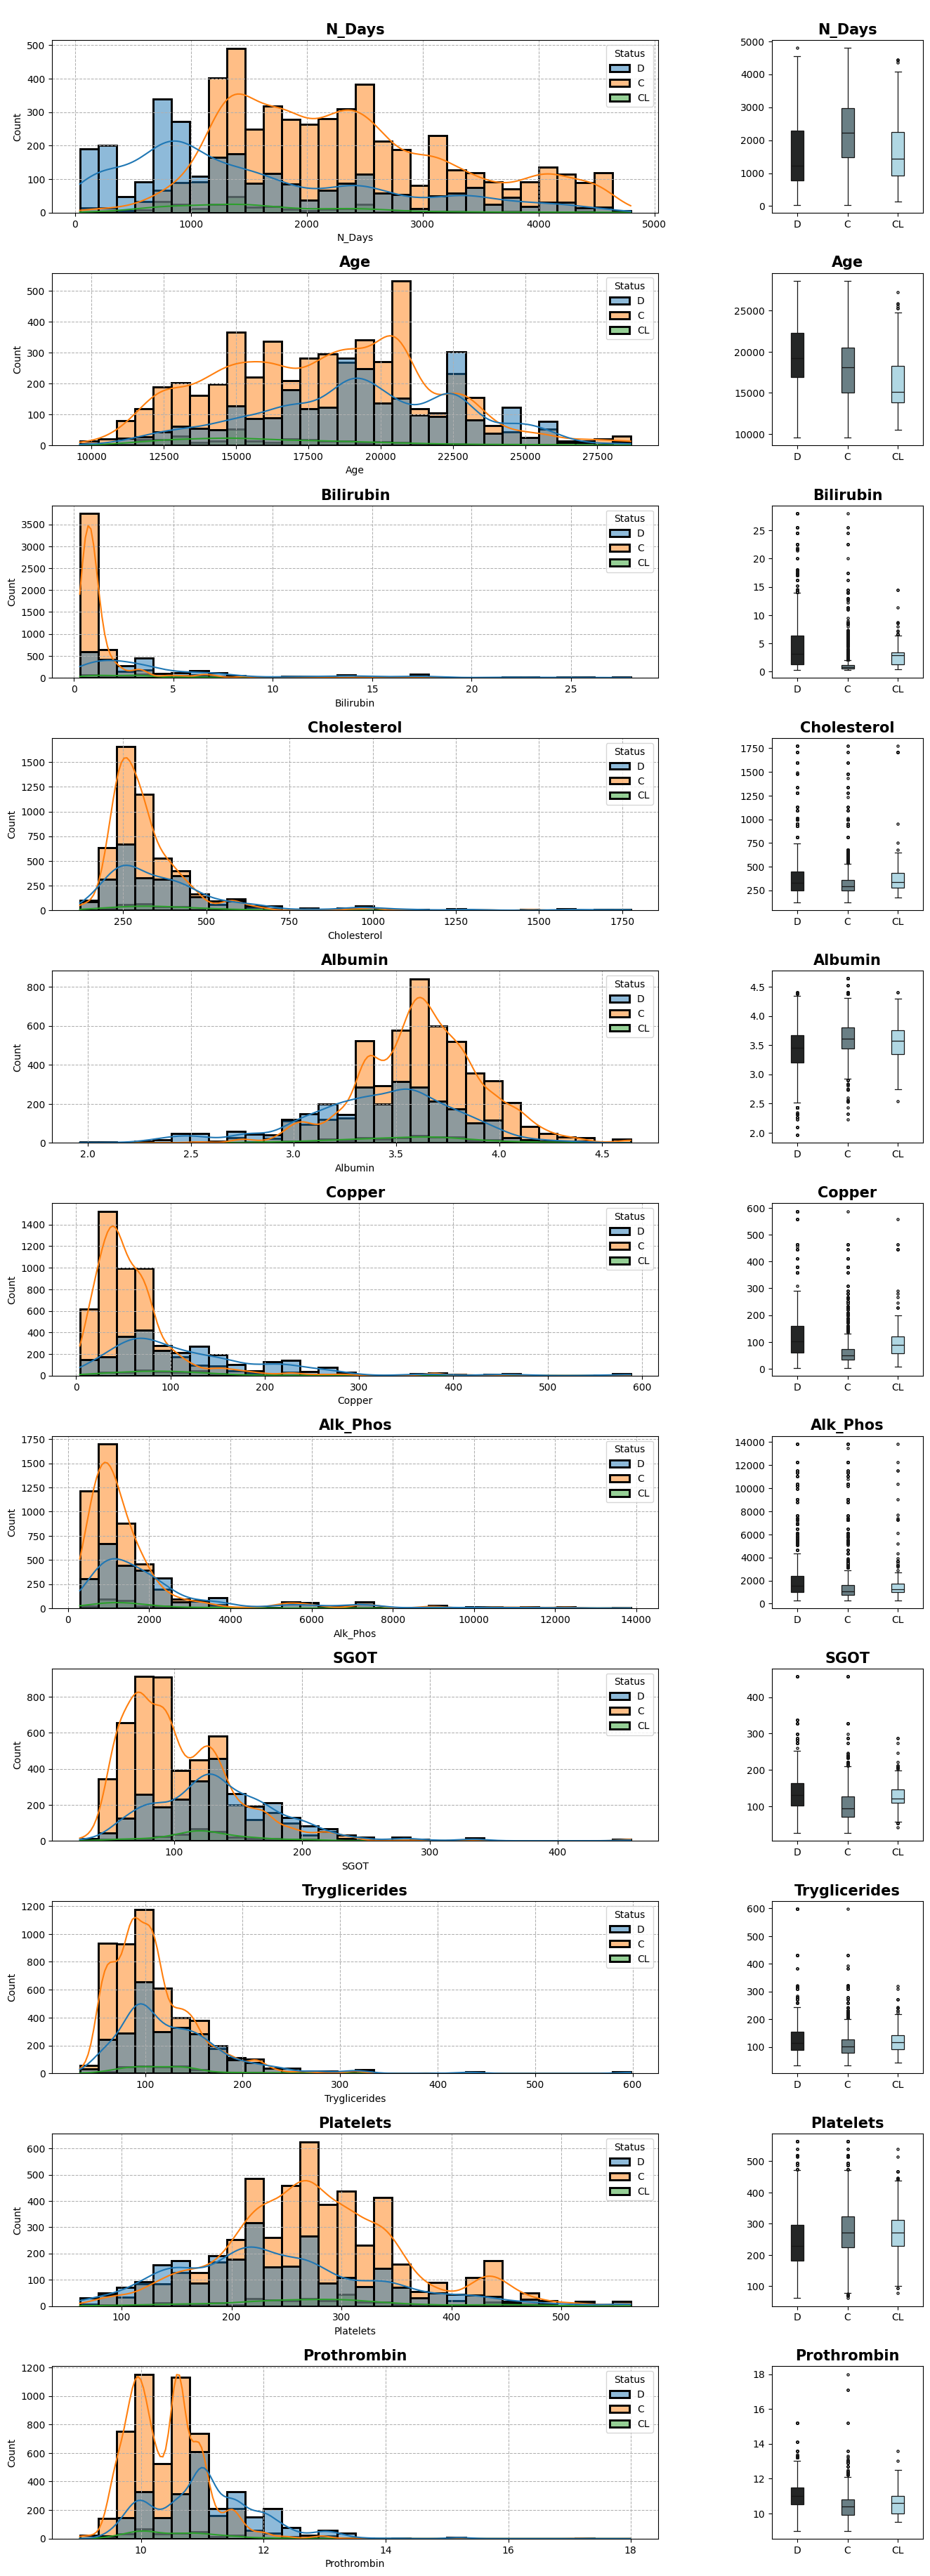

In [ ]:
distribution_box_plot(data_set=df, variables=num_var, target=target)

* Most clinical features (Bilirubin, Copper, Alk_Phos, SGOT, Triglycerides, Prothrombin) show non-normal, right-skewed distributions with outliers more frequent in the ‘D’ group, reflecting disease severity. CL group distributions tend to cluster around healthier values.

**Distribution of Target**

In [ ]:
def plot_count(data_set=df, col_list=[target]):
    f, ax = plt.subplots(len(col_list), 2, figsize=(12, 5))
    plt.subplots_adjust(wspace=0.3)

    for col in col_list:
        s1 = data_set[col].value_counts()
        N = len(s1)

        ax[0].pie(s1, labels=s1.index.tolist(),
                    startangle=90, frame=True, radius=1.2,
                    explode=([0.05]*(N-1) + [.2]),
                    wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
                    textprops={'fontsize': 10, 'weight': 'bold'},
                    autopct='%1.f%%',
                    shadow=True,
                    )

        sns.barplot(x=s1, y=s1.index, ax=ax[1], orient='horizontal', color='#82B0D2')

        ax[1].spines['top'].set_visible(False)
        ax[1].spines['right'].set_visible(False)
        ax[1].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
        ax[1].set_ylabel('')  # Remove y label

        for i, v in enumerate(s1):
            ax[1].text(v, i+0.1, str(v), color='black', fontweight='bold', fontsize=14)

        # Adding labels and title
        plt.setp(ax[1].get_yticklabels(), fontweight="bold")
        plt.setp(ax[1].get_xticklabels(), fontweight="bold")
        ax[1].set_xlabel(col, fontweight="bold", color='black', fontsize=14)

    f.suptitle(f'Distribution of {col}', fontsize=20, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.show()

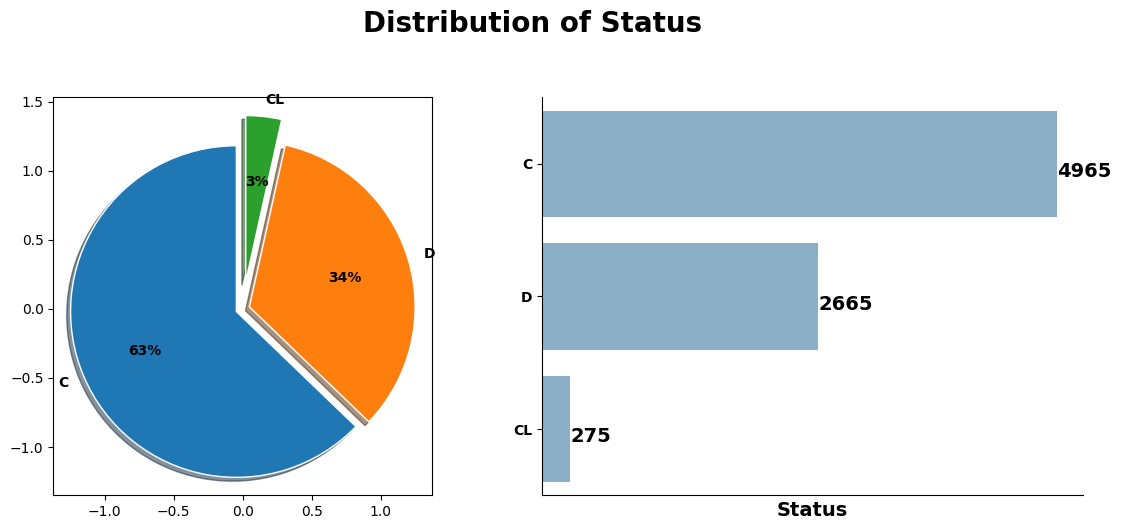

In [ ]:
plot_count(data_set = df, col_list = [target])


**Distribution of Category Variables**

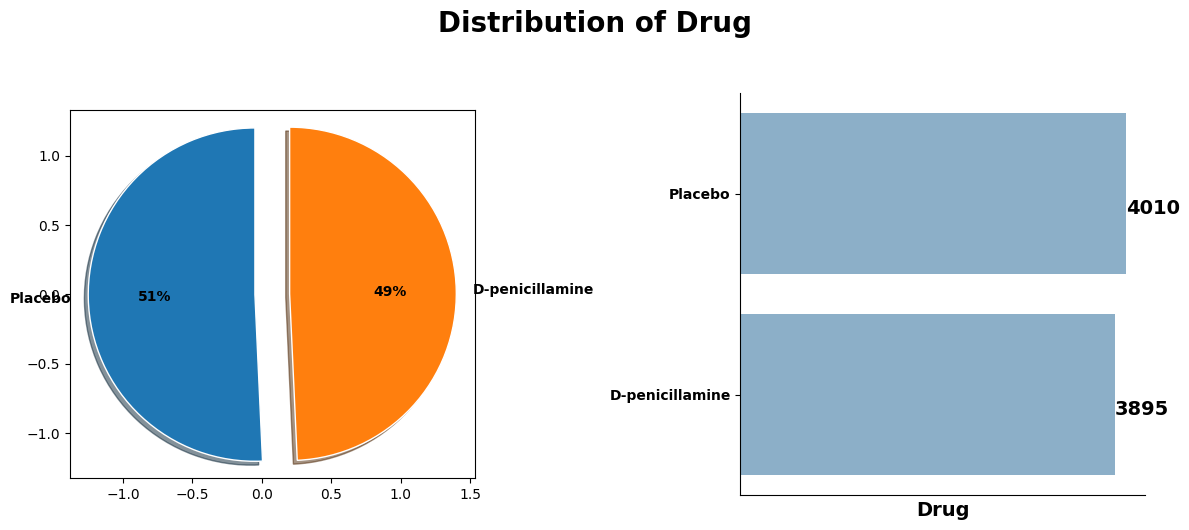

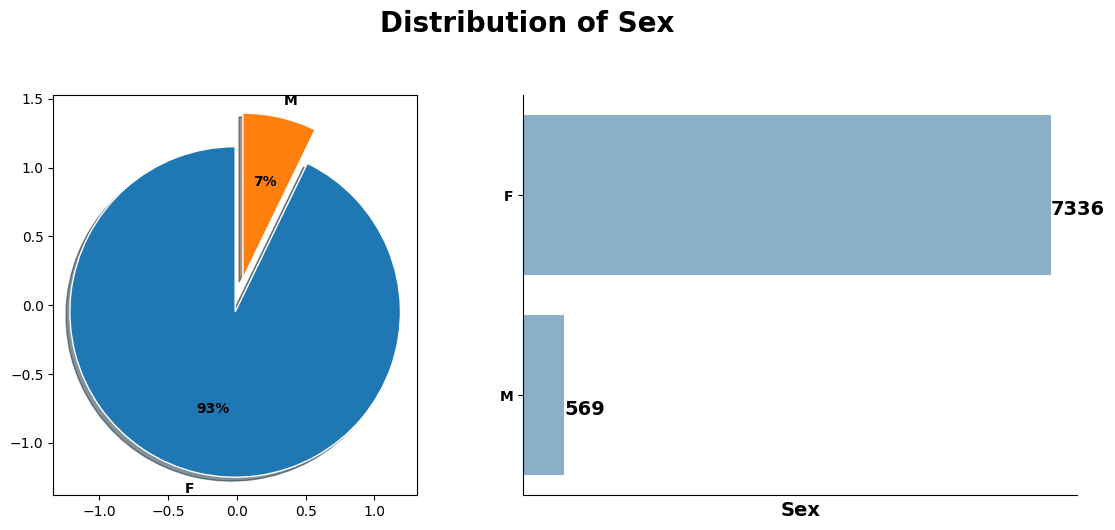

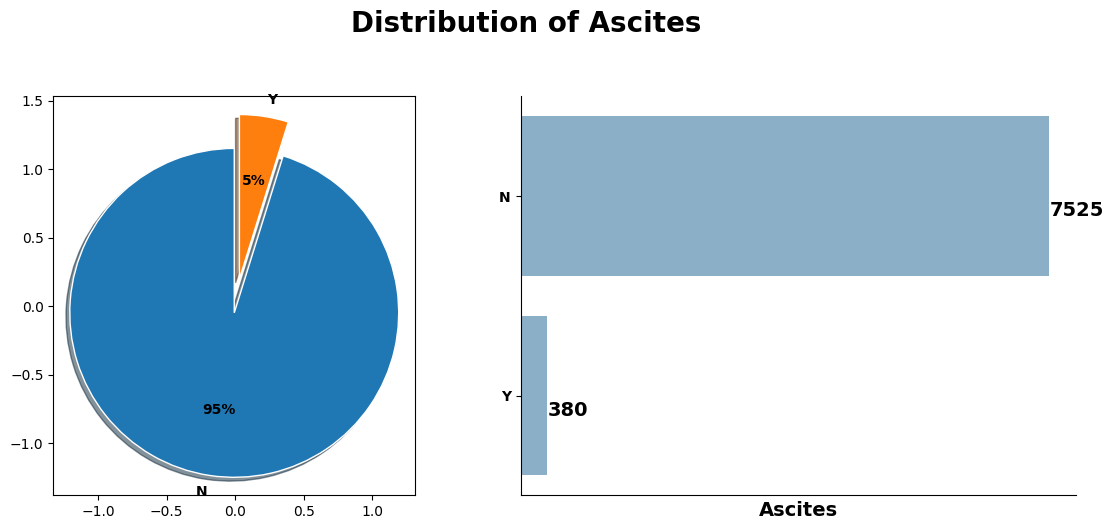

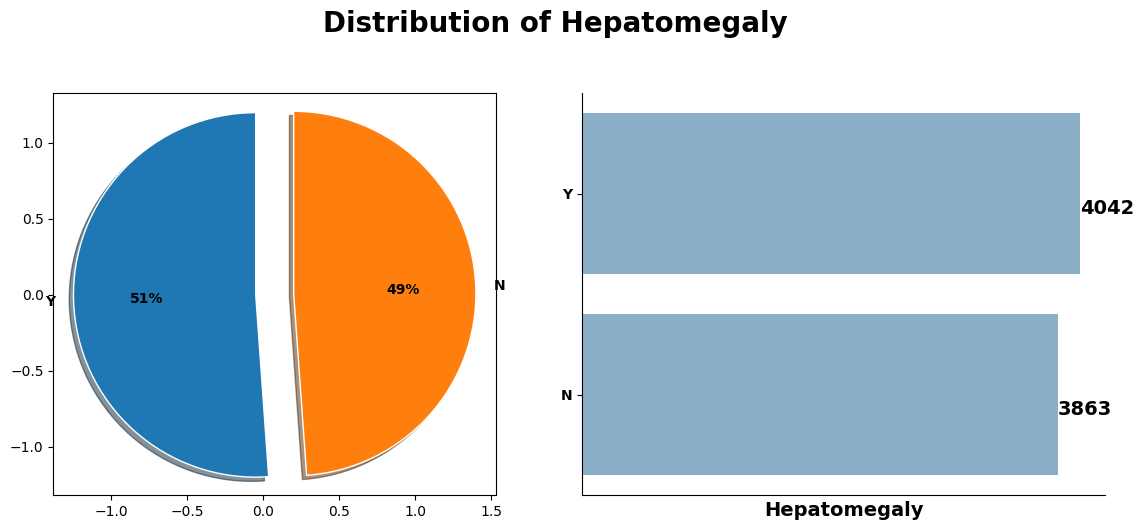

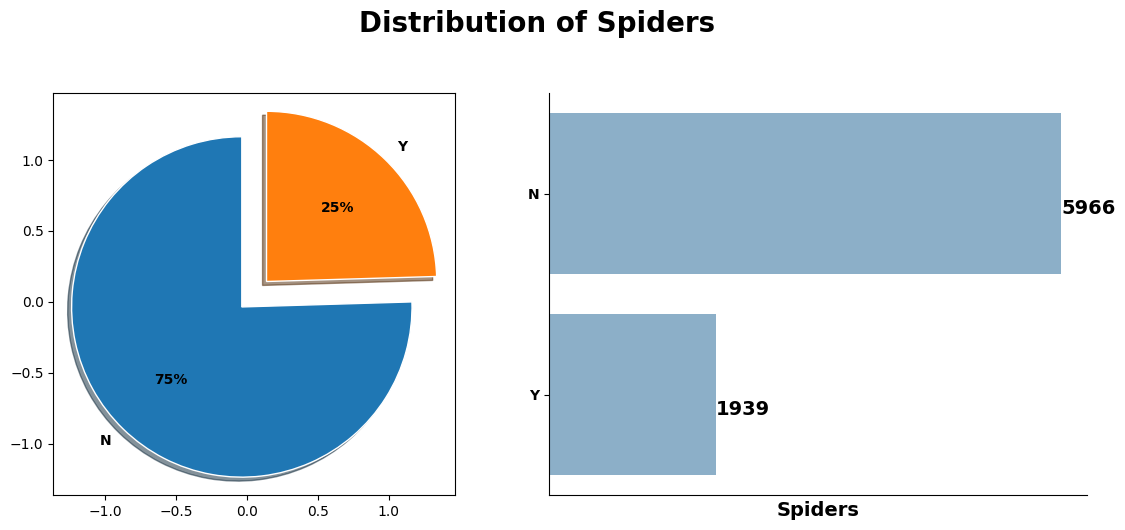

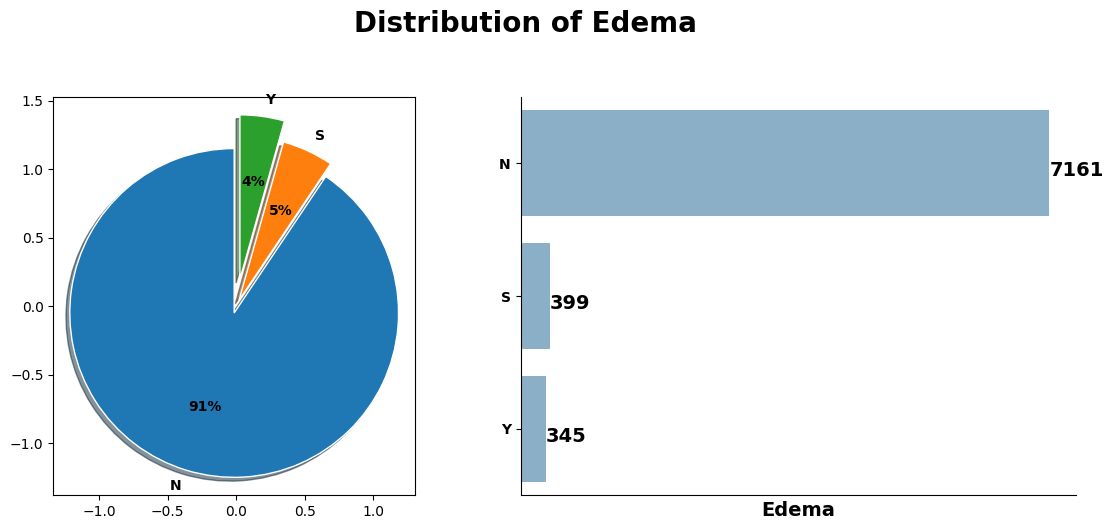

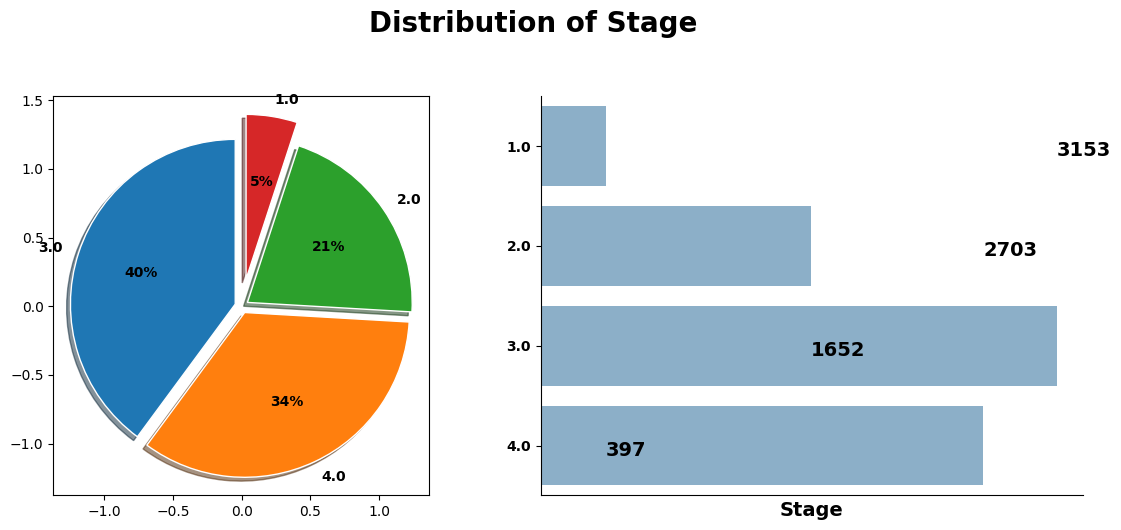

In [ ]:
for var in cat_var:
    plot_count(data_set=df, col_list=[var])

**Observation:**

* The distribution of some data is extremely unbalanced, for example: Sex, Ascites, Edema, Stage.

**Distribution of Category Variables - Target**

In [ ]:
def plot_count_cate_target(data_set=None, variables=None, target=None):
    if data_set is None or variables is None or target is None:
        raise ValueError("Please provide data_set, variables, and target.")

    plt.figure(figsize=(14,len(variables)*2))
    for idx,column in enumerate(variables):
        plt.subplot(len(cat_var)//2+1,2,idx+1)
        sns.countplot(x=target, hue=column, data=data_set,color='#82B0D2')
        plt.title(f"{column} Distribution")
        plt.tight_layout()

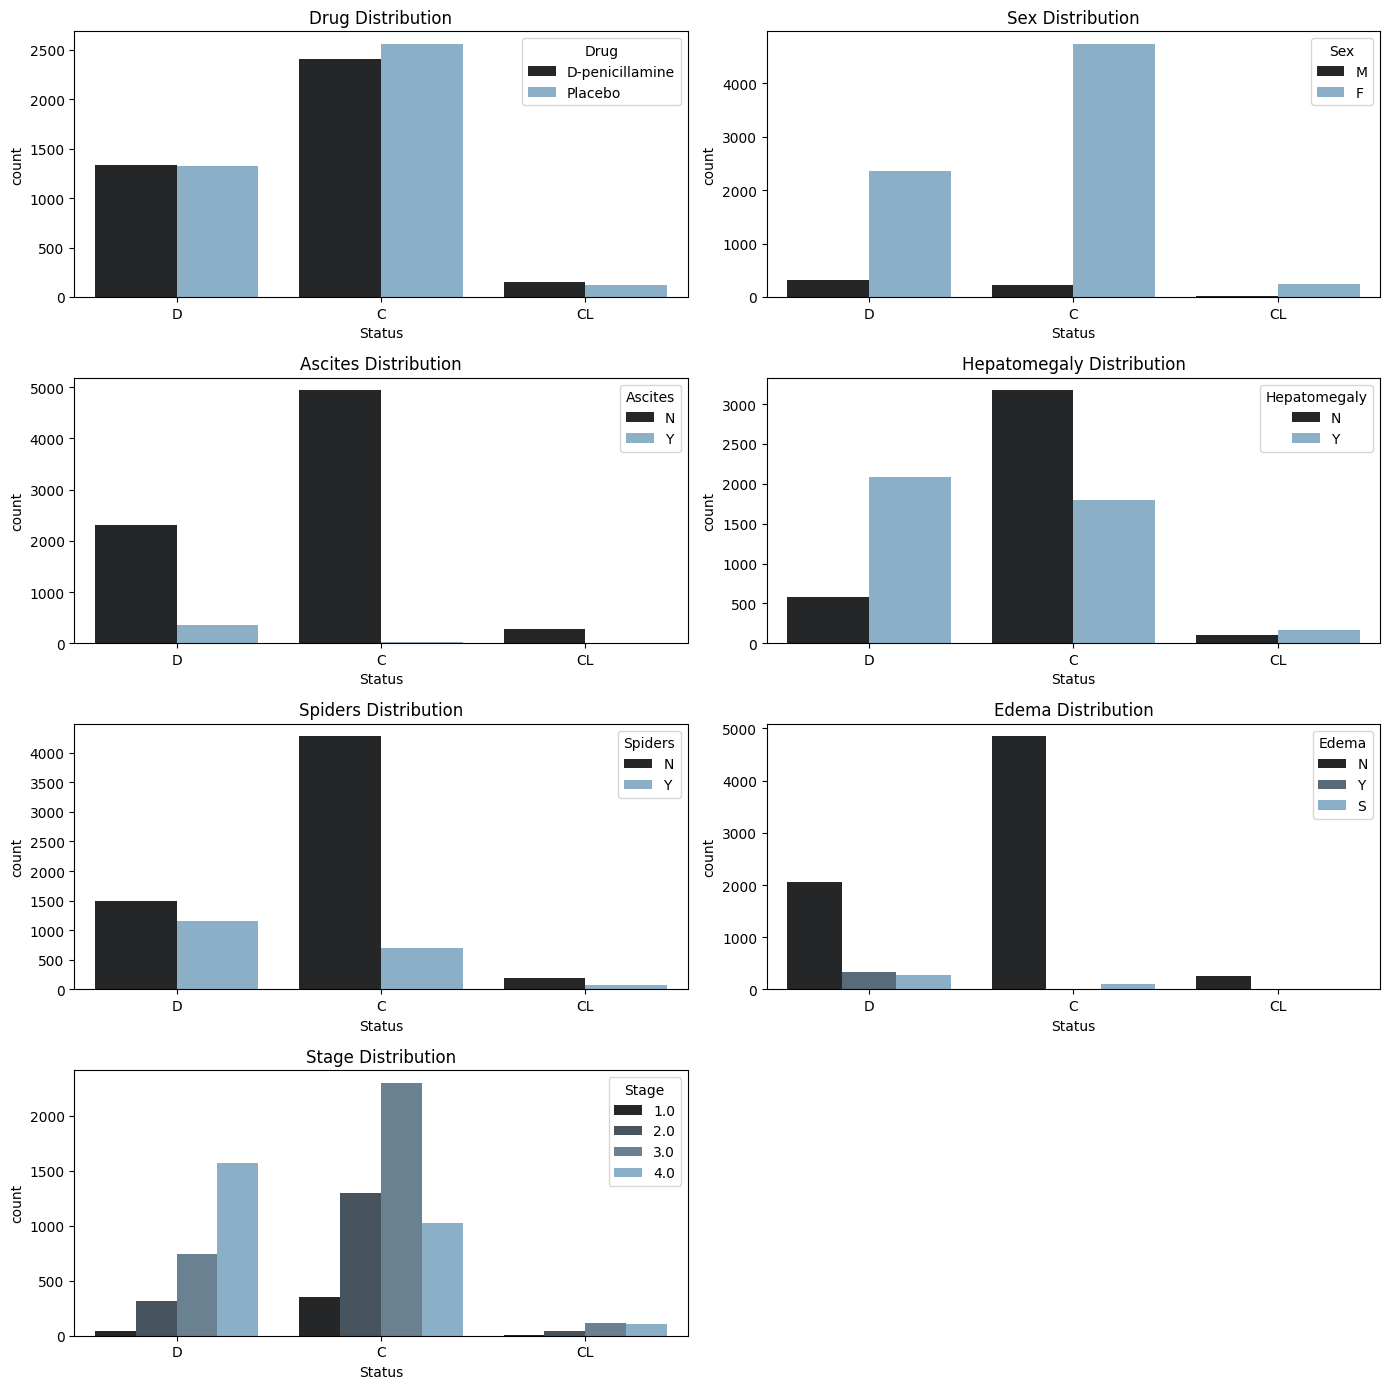

In [ ]:
plot_count_cate_target(data_set=df, variables=cat_var, target=target)


# Preprocessing

## Label & Feature Encoding


In [ ]:
def data_preprocess(dataset=None, if_test=None):
    df = dataset.copy()
    df["Drug"] = df["Drug"].map({"Placebo": 0, "D-penicillamine": 1})
    df["Sex"] = df["Sex"].map({"M": 0, "F": 1})
    df['Edema'] = df['Edema'].map({"N":0, "Y":1, "S":2})

    #df = pd.get_dummies(df, columns=['Edema'], drop_first=True)

    for col in ["Ascites", "Hepatomegaly", "Spiders"]:
        df[col] = df[col].map({"N": 0, "Y": 1})
    if not if_test:
        df['Status'] = df['Status'].map({"D": 0, "CL": 1, "C": 2})
    return df

In [ ]:
def features_engineering(dataset=None):
    df = dataset.copy()
    df['date_of_diagnosis'] = df['Age'] - df['N_Days']
    df['diseases'] = df['Ascites'] + df['Hepatomegaly'] + df['Spiders'] + df['Edema']
    df['Albumin_Level'] = np.where(df['Albumin'] < 3.4, 1, np.where(df['Albumin'] > 5.4, 2, 0))
    df['Copper_Risk'] = np.where(df['Copper'] > 140, 1, 0)
    df['Platelets_Normal'] = np.where((df['Platelets'] >= 150_000) & (df['Platelets'] <= 450_000),0,1)


    return df

In [ ]:
df_pre = data_preprocess(dataset=df, if_test=False)
df_eng = features_engineering(dataset=df_pre)
df_eng

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,...,Tryglicerides,Platelets,Prothrombin,Stage,Status,date_of_diagnosis,diseases,Albumin_Level,Copper_Risk,Platelets_Normal
0,999,1,21532,0,0,0,0,0,2.3,316.0,...,63.0,394.0,9.7,3.0,0,20533,0,1,1,1
1,2574,0,19237,1,0,0,0,0,0.9,364.0,...,88.0,361.0,11.0,3.0,2,16663,0,0,0,1
2,3428,0,13727,1,0,1,1,1,3.3,299.0,...,50.0,199.0,11.7,4.0,0,10299,3,0,0,1
3,2576,0,18460,1,0,0,0,0,0.6,256.0,...,96.0,269.0,10.7,3.0,2,15884,0,0,0,1
4,788,0,16658,1,0,1,0,0,1.1,346.0,...,96.0,298.0,10.6,4.0,2,15870,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7900,1166,1,16839,1,0,0,0,0,0.8,309.0,...,224.0,344.0,9.9,2.0,2,15673,0,0,0,1
7901,1492,0,17031,1,0,1,0,0,0.9,260.0,...,78.0,277.0,10.0,4.0,2,15539,1,0,0,1
7902,1576,1,25873,1,0,0,1,2,2.0,225.0,...,62.0,200.0,12.7,2.0,0,24297,3,1,0,1
7903,3584,1,22960,0,0,1,0,0,0.7,248.0,...,118.0,221.0,10.6,4.0,0,19376,1,1,0,1


In [ ]:
tmp_df = df_eng.copy()

# Calculate the mean and standard deviation for each column
means = tmp_df[num_var].mean()
std_devs = tmp_df[num_var].std()

# Define a threshold for what you consider to be an outlier, typically 6 standard deviations from the mean
n_stds = 6
thresholds = n_stds * std_devs

# Detect outliers
outliers = (np.abs(tmp_df[num_var] - means) > thresholds).any(axis=1)

print(f"Detected {sum(outliers)} that are more than {n_stds} SDs away from mean...")

Detected 166 that are more than 6 SDs away from mean...


In [ ]:
outliers_df = df_eng[outliers]

df_eng = df_eng[~outliers].reset_index(drop=True)
print(f"Data shape after outlier removal: {df_eng.shape}")

Data shape after outlier removal: (7739, 24)


In [ ]:
def log_transform(dataset=None, skewed_features=None):
  df = dataset.copy()
  for feature in skewed_features:
      df[f'{feature}_log'] = np.log1p(df[feature])
  return df

In [ ]:
skewed_features = ['Bilirubin', 'Copper', 'Alk_Phos', 'SGOT','Tryglicerides', 'Prothrombin']
df_eng = log_transform(dataset=df_eng, skewed_features=skewed_features)


## Another encoding

In [ ]:
# data = df.copy()
# # Encode the label
# label_encoder = LabelEncoder()
# data[target] = label_encoder.fit_transform(data[target])
# data

In [ ]:
# encoders = {
#     'Drug': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, categories=[['Placebo', 'D-penicillamine']]),
#     'Sex': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
#     'Ascites': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
#     'Hepatomegaly': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
#     'Spiders': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
#     # 'Edema': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, categories=[['N', 'S', 'Y']]),
#     'Edema': OneHotEncoder(),
#     'Stage': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
# }

In [ ]:
# for feat, enc in encoders.items():
#     if isinstance(enc, OrdinalEncoder):
#         data[feat] = enc.fit_transform(data[[feat]]).astype('int32')
#     if isinstance(enc, OneHotEncoder):
#         # Transform and get new column names
#         new_cols = enc.fit_transform(data[[feat]]).toarray().astype('int8')
#         # col_names = [f"{feat}_{cat}" for cat in enc.categories_[0]]
#         col_names = enc.get_feature_names_out()

#         # Add new columns to the dataframe
#         data[col_names] = new_cols
#         data.drop(feat, axis=1, inplace=True)  # Drop original column



# Modeling

**PS**: dont try run svm takes much time for worthless accuracy

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import warnings

warnings.filterwarnings("ignore")  # Clean output

def best_classifier(X_train, y_train, X_test, y_test, scoring='accuracy', cv=5):
    models = {
        "Logistic Regression": {
            "model": LogisticRegression(),
            "params": {
                'C': [0.01, 0.1, 1, 10],
                'solver': ['liblinear', 'lbfgs']
            }
        },
        "Decision Tree": {
            "model": DecisionTreeClassifier(),
            "params": {
                'max_depth': [3, 5, 10, None],
                'criterion': ['gini', 'entropy']
            }
        },
        "Random Forest": {
            "model": RandomForestClassifier(),
            "params": {
                'n_estimators': [50, 100],
                'max_depth': [5, 10, None]
            }
        },
        # "SVM": {
        #     "model": SVC(),
        #     "params": {
        #         'C': [0.1, 1, 10],
        #         'kernel': ['linear', 'rbf']
        #     }
        # },
        "AdaBoost": {
            "model": AdaBoostClassifier(),
            "params": {
                'n_estimators': [50, 100],
                'learning_rate': [0.5, 1, 1.5]
            }
        },
        "XGBoost": {
            "model": XGBClassifier(eval_metric='logloss', use_label_encoder=False),
            "params": {
                'n_estimators': [50, 100],
                'learning_rate': [0.05, 0.1, 0.2],
                'max_depth': [3, 5]
            }
        }
    }

    best_score = 0
    best_model = None
    best_name = ""

    for name, config in models.items():
        print(f"\n🔍 Running GridSearchCV for: {name}")
        grid = GridSearchCV(config["model"], config["params"], scoring=scoring, cv=cv, n_jobs=-1)
        grid.fit(X_train, y_train)
        preds = grid.predict(X_test)
        score = grid.score(X_test, y_test)
        print(f"✅ {name} Accuracy: {score:.4f}")
        print("📊 Classification Report:\n", classification_report(y_test, preds))
        print("🔧 Best Hyperparameters:", grid.best_params_)

        if score > best_score:
            best_score = score
            best_model = grid.best_estimator_
            best_name = name

    print(f"\n🏆 Best Model: {best_name} with accuracy: {best_score:.4f}")
    return best_model


In [ ]:
from sklearn.model_selection import train_test_split
X = df_eng.drop('Status', axis=1)
y = df_eng['Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
best = best_classifier(X_train_scaled, y_train, X_test_scaled, y_test)


🔍 Running GridSearchCV for: Logistic Regression
✅ Logistic Regression Accuracy: 0.8010
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.69      0.71       499
           1       0.00      0.00      0.00        47
           2       0.83      0.89      0.86      1002

    accuracy                           0.80      1548
   macro avg       0.52      0.53      0.52      1548
weighted avg       0.77      0.80      0.79      1548

🔧 Best Hyperparameters: {'C': 0.01, 'solver': 'liblinear'}

🔍 Running GridSearchCV for: Decision Tree
✅ Decision Tree Accuracy: 0.8056
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.66      0.71       499
           1       0.00      0.00      0.00        47
           2       0.82      0.92      0.87      1002

    accuracy                           0.81      1548
   macro avg       0.53      0.52      0.52      1548
weighted avg      

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
best = best_classifier(X_train_scaled, y_train, X_test_scaled, y_test)


🔍 Running GridSearchCV for: Logistic Regression
✅ Logistic Regression Accuracy: 0.8023
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.69      0.71       499
           1       0.00      0.00      0.00        47
           2       0.83      0.90      0.86      1002

    accuracy                           0.80      1548
   macro avg       0.52      0.53      0.52      1548
weighted avg       0.78      0.80      0.79      1548

🔧 Best Hyperparameters: {'C': 0.01, 'solver': 'liblinear'}

🔍 Running GridSearchCV for: Decision Tree
✅ Decision Tree Accuracy: 0.8056
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.66      0.71       499
           1       0.00      0.00      0.00        47
           2       0.82      0.92      0.87      1002

    accuracy                           0.81      1548
   macro avg       0.53      0.52      0.52      1548
weighted avg      

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
best = best_classifier(X_train_scaled, y_train, X_test_scaled, y_test)


🔍 Running GridSearchCV for: Logistic Regression
✅ Logistic Regression Accuracy: 0.8010
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.69      0.71       499
           1       0.00      0.00      0.00        47
           2       0.83      0.89      0.86      1002

    accuracy                           0.80      1548
   macro avg       0.52      0.53      0.52      1548
weighted avg       0.77      0.80      0.79      1548

🔧 Best Hyperparameters: {'C': 1, 'solver': 'liblinear'}

🔍 Running GridSearchCV for: Decision Tree
✅ Decision Tree Accuracy: 0.8056
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.66      0.71       499
           1       0.00      0.00      0.00        47
           2       0.82      0.92      0.87      1002

    accuracy                           0.81      1548
   macro avg       0.53      0.52      0.52      1548
weighted avg       0.

In [ ]:
# Standard Scaler was the best.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

best.fit(X_train_scaled, y_train)
y_train_pred = best.predict(X_train_scaled)
y_test_pred = best.predict(X_test_scaled)

print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

Train Accuracy: 0.8985624293329026
Test Accuracy: 0.838501291989664


In [ ]:
from sklearn.ensemble import VotingClassifier, StackingClassifier

def create_ensembles(best_models_dict, X_train, y_train, X_test, y_test):
    estimators = [(name, model) for name, model in best_models_dict.items()]

    # 1. Hard Voting Ensemble
    voting = VotingClassifier(estimators=estimators, voting='hard')
    voting.fit(X_train, y_train)
    voting_score = voting.score(X_test, y_test)
    print(f"\n🗳️ Hard Voting Accuracy: {voting_score:.4f}")

    # 2. Soft Voting Ensemble
    if all(hasattr(m[1], 'predict_proba') for m in estimators):
        voting_soft = VotingClassifier(estimators=estimators, voting='soft')
        voting_soft.fit(X_train, y_train)
        soft_score = voting_soft.score(X_test, y_test)
        print(f"☁️ Soft Voting Accuracy: {soft_score:.4f}")

    # 3. Stacking Ensemble
    stack = StackingClassifier(estimators=estimators,
                             final_estimator=LogisticRegression(),
                             cv=5)
    stack.fit(X_train, y_train)
    stack_score = stack.score(X_test, y_test)
    print(f"🛠️ Stacking Accuracy: {stack_score:.4f}")

    return {
        'voting': voting,
        'voting_soft': voting_soft if 'voting_soft' in locals() else None,
        'stacking': stack
    }

In [ ]:
best_lr_params = {'C': 0.01, 'solver': 'liblinear'}
best_dt_params = {'criterion': 'gini', 'max_depth': 5}
best_rf_params = {'max_depth': None, 'n_estimators': 100}
best_ab_params = {'learning_rate': 1, 'n_estimators': 100}
best_xgb_params = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

best_models = {
    # "Logistic Regression": LogisticRegression(**best_lr_params),
    # "Decision Tree": DecisionTreeClassifier(**best_dt_params),
    "Random Forest": RandomForestClassifier(**best_rf_params),
    "AdaBoost": AdaBoostClassifier(**best_ab_params),
    "XGBoost": XGBClassifier(**best_xgb_params, eval_metric='logloss')
}

ensembles = create_ensembles(best_models, X_train_scaled, y_train, X_test_scaled, y_test)

final_predictions = ensembles['stacking'].predict(X_test_scaled)


🗳️ Hard Voting Accuracy: 0.8359
☁️ Soft Voting Accuracy: 0.8340
🛠️ Stacking Accuracy: 0.8353


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

def create_weighted_ensemble(best_models_dict, X_train, y_train, X_test, y_test):
    """
    Creates a weighted ensemble based on individual model performance

    Parameters:
    best_models_dict: Dictionary of {'model_name': trained_model}
    Returns trained VotingClassifier with optimized weights
    """

    estimators = [(name, model) for name, model in best_models_dict.items()]

    weights = []
    for name, model in estimators:
        acc = model.score(X_test, y_test)
        weights.append(acc)
        print(f"{name} Accuracy: {acc:.4f}")

    weights = [w/sum(weights) for w in weights]

    weighted_ensemble = VotingClassifier(
        estimators=estimators,
        voting='hard',
        weights=weights
    )

    weighted_ensemble.fit(X_train, y_train)

    ensemble_acc = weighted_ensemble.score(X_test, y_test)
    print(f"\n🔮 Weighted Ensemble Accuracy: {ensemble_acc:.4f}")
    print("⚖️ Model Weights:", dict(zip(best_models_dict.keys(), weights)))

    return weighted_ensemble

In [ ]:
best_lr_params = {'C': 0.01, 'solver': 'liblinear'}
best_dt_params = {'criterion': 'gini', 'max_depth': 5}
best_rf_params = {'max_depth': None, 'n_estimators': 100}
best_ab_params = {'learning_rate': 1, 'n_estimators': 100}
best_xgb_params = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

best_models = {
    # "Logistic Regression": LogisticRegression(**best_lr_params).fit(X_train_scaled, y_train),
    # "Decision Tree": DecisionTreeClassifier(**best_dt_params).fit(X_train_scaled, y_train),
    "Random Forest": RandomForestClassifier(**best_rf_params).fit(X_train_scaled, y_train),
    "AdaBoost": AdaBoostClassifier(**best_ab_params).fit(X_train_scaled, y_train),
    "XGBoost": XGBClassifier(**best_xgb_params, eval_metric='logloss').fit(X_train_scaled, y_train)
}

weighted_ensemble = create_weighted_ensemble(best_models, X_train_scaled, y_train, X_test_scaled, y_test)

Random Forest Accuracy: 0.8340
AdaBoost Accuracy: 0.8217
XGBoost Accuracy: 0.8385

🔮 Weighted Ensemble Accuracy: 0.8359
⚖️ Model Weights: {'Random Forest': 0.33436933436933436, 'AdaBoost': 0.32944832944832947, 'XGBoost': 0.33618233618233617}


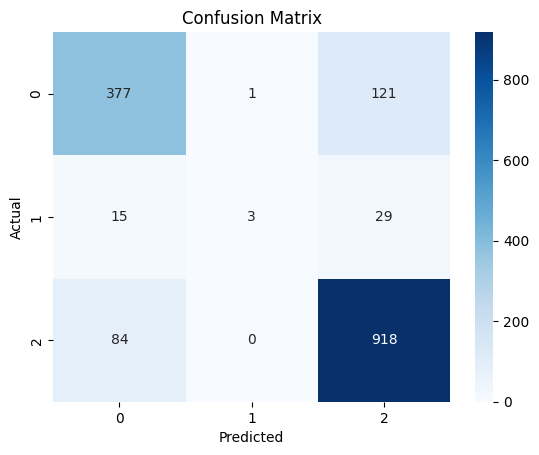

In [ ]:
# plot confusion matrix for best model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = best.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
import warnings
import time

warnings.filterwarnings("ignore")  # Clean output

def best_classifier_with_pca(X_train, y_train, X_test, y_test, scoring='accuracy', cv=5, verbose=1):
    # Models that benefit from standardization and PCA
    models_with_scaling_pca = {
        "Logistic Regression with PCA": {
            "steps": [
                ("scaler", StandardScaler()),
                ("pca", PCA()),
                ("model", LogisticRegression(max_iter=1000))
            ],
            "params": {
                'pca__n_components': [0.85, 0.9, 0.95],  # Explained variance ratio
                'model__C': [0.01, 0.1, 1, 10],
                'model__solver': ['liblinear', 'lbfgs']
            }
        },
        "SVM with PCA": {
            "steps": [
                ("scaler", StandardScaler()),
                ("pca", PCA()),
                ("model", SVC())
            ],
            "params": {
                'pca__n_components': [0.85, 0.9, 0.95],  # Explained variance ratio
                'model__C': [0.1, 1, 10],
                'model__kernel': ['linear', 'rbf']
            }
        }
    }

    # Models that benefit from standardization but without PCA
    models_with_scaling = {
        "Logistic Regression": {
            "steps": [
                ("scaler", StandardScaler()),
                ("model", LogisticRegression(max_iter=1000))
            ],
            "params": {
                'model__C': [0.01, 0.1, 1, 10],
                'model__solver': ['liblinear', 'lbfgs']
            }
        },
        "SVM": {
            "steps": [
                ("scaler", StandardScaler()),
                ("model", SVC())
            ],
            "params": {
                'model__C': [0.1, 1, 10],
                'model__kernel': ['linear', 'rbf']
            }
        }
    }

    # Models that don't necessarily need standardization
    models_without_scaling = {
        "Decision Tree": {
            "model": DecisionTreeClassifier(),
            "params": {
                'max_depth': [3, 5, 10, None],
                'criterion': ['gini', 'entropy']
            }
        },
        "Random Forest": {
            "model": RandomForestClassifier(),
            "params": {
                'n_estimators': [50, 100],
                'max_depth': [5, 10, None],
                'n_jobs': [-1]  # Use all available cores
            }
        },
        "AdaBoost": {
            "model": AdaBoostClassifier(),
            "params": {
                'n_estimators': [50, 100],
                'learning_rate': [0.5, 1, 1.5]
            }
        },
        "XGBoost": {
            "model": XGBClassifier(eval_metric='logloss', use_label_encoder=False),
            "params": {
                'n_estimators': [50, 100],
                'learning_rate': [0.05, 0.1, 0.2],
                'max_depth': [3, 5],
                'n_jobs': [-1]  # Use all available cores
            }
        }
    }

    # Models with PCA but without standardization (some tree-based models can benefit from PCA)
    models_with_pca = {
        "Random Forest with PCA": {
            "steps": [
                ("pca", PCA()),
                ("model", RandomForestClassifier())
            ],
            "params": {
                'pca__n_components': [0.85, 0.9, 0.95],  # Explained variance ratio
                'model__n_estimators': [50, 100],
                'model__max_depth': [5, 10, None],
                'model__n_jobs': [-1]  # Use all available cores
            }
        },
        "XGBoost with PCA": {
            "steps": [
                ("pca", PCA()),
                ("model", XGBClassifier(eval_metric='logloss', use_label_encoder=False))
            ],
            "params": {
                'pca__n_components': [0.85, 0.9, 0.95],  # Explained variance ratio
                'model__n_estimators': [50, 100],
                'model__learning_rate': [0.05, 0.1, 0.2],
                'model__max_depth': [3, 5],
                'model__n_jobs': [-1]  # Use all available cores
            }
        }
    }

    best_score = 0
    best_model = None
    best_name = ""
    results = {}

    # Process models with scaling and PCA
    for name, config in models_with_scaling_pca.items():
        if verbose:
            print(f"\n🔍 Running GridSearchCV for: {name} (with standardization and PCA)")

        start_time = time.time()
        pipeline = Pipeline(config["steps"])
        grid = GridSearchCV(pipeline, config["params"], scoring=scoring, cv=cv, n_jobs=-1)
        grid.fit(X_train, y_train)
        preds = grid.predict(X_test)
        score = grid.score(X_test, y_test)
        elapsed_time = time.time() - start_time

        results[name] = {
            "score": score,
            "model": grid.best_estimator_,
            "params": grid.best_params_,
            "time": elapsed_time
        }

        if verbose:
            print(f"✅ {name} Accuracy: {score:.4f} (Time: {elapsed_time:.2f}s)")
            print("📊 Classification Report:\n", classification_report(y_test, preds))
            print("🔧 Best Hyperparameters:", grid.best_params_)

        if score > best_score:
            best_score = score
            best_model = grid.best_estimator_
            best_name = name

    # Process models with scaling
    for name, config in models_with_scaling.items():
        if verbose:
            print(f"\n🔍 Running GridSearchCV for: {name} (with standardization)")

        start_time = time.time()
        pipeline = Pipeline(config["steps"])
        grid = GridSearchCV(pipeline, config["params"], scoring=scoring, cv=cv, n_jobs=-1)
        grid.fit(X_train, y_train)
        preds = grid.predict(X_test)
        score = grid.score(X_test, y_test)
        elapsed_time = time.time() - start_time

        results[name] = {
            "score": score,
            "model": grid.best_estimator_,
            "params": grid.best_params_,
            "time": elapsed_time
        }

        if verbose:
            print(f"✅ {name} Accuracy: {score:.4f} (Time: {elapsed_time:.2f}s)")
            print("📊 Classification Report:\n", classification_report(y_test, preds))
            print("🔧 Best Hyperparameters:", grid.best_params_)

        if score > best_score:
            best_score = score
            best_model = grid.best_estimator_
            best_name = name

    # Process models with PCA but without standardization
    for name, config in models_with_pca.items():
        if verbose:
            print(f"\n🔍 Running GridSearchCV for: {name} (with PCA)")

        start_time = time.time()
        pipeline = Pipeline(config["steps"])
        grid = GridSearchCV(pipeline, config["params"], scoring=scoring, cv=cv, n_jobs=-1)
        grid.fit(X_train, y_train)
        preds = grid.predict(X_test)
        score = grid.score(X_test, y_test)
        elapsed_time = time.time() - start_time

        results[name] = {
            "score": score,
            "model": grid.best_estimator_,
            "params": grid.best_params_,
            "time": elapsed_time
        }

        if verbose:
            print(f"✅ {name} Accuracy: {score:.4f} (Time: {elapsed_time:.2f}s)")
            print("📊 Classification Report:\n", classification_report(y_test, preds))
            print("🔧 Best Hyperparameters:", grid.best_params_)

        if score > best_score:
            best_score = score
            best_model = grid.best_estimator_
            best_name = name

    # Process models without scaling
    for name, config in models_without_scaling.items():
        if verbose:
            print(f"\n🔍 Running GridSearchCV for: {name}")

        start_time = time.time()
        grid = GridSearchCV(config["model"], config["params"], scoring=scoring, cv=cv, n_jobs=-1)
        grid.fit(X_train, y_train)
        preds = grid.predict(X_test)
        score = grid.score(X_test, y_test)
        elapsed_time = time.time() - start_time

        results[name] = {
            "score": score,
            "model": grid.best_estimator_,
            "params": grid.best_params_,
            "time": elapsed_time
        }

        if verbose:
            print(f"✅ {name} Accuracy: {score:.4f} (Time: {elapsed_time:.2f}s)")
            print("📊 Classification Report:\n", classification_report(y_test, preds))
            print("🔧 Best Hyperparameters:", grid.best_params_)

        if score > best_score:
            best_score = score
            best_model = grid.best_estimator_
            best_name = name

    if verbose:
        print("\n📋 Summary of Results:")
        for name, result in results.items():
            print(f"- {name}: Score = {result['score']:.4f}, Time = {result['time']:.2f}s")
        print(f"\n🏆 Best Model: {best_name} with accuracy: {best_score:.4f}")

    return best_model

In [ ]:
best = best_classifier_with_pca(X_train_scaled, y_train, X_test_scaled, y_test)


🔍 Running GridSearchCV for: Logistic Regression with PCA (with standardization and PCA)
✅ Logistic Regression with PCA Accuracy: 0.7997 (Time: 3.41s)
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.68      0.71       499
           1       0.00      0.00      0.00        47
           2       0.83      0.90      0.86      1002

    accuracy                           0.80      1548
   macro avg       0.52      0.53      0.52      1548
weighted avg       0.77      0.80      0.78      1548

🔧 Best Hyperparameters: {'model__C': 1, 'model__solver': 'liblinear', 'pca__n_components': 0.95}

🔍 Running GridSearchCV for: SVM with PCA (with standardization and PCA)
✅ SVM with PCA Accuracy: 0.7997 (Time: 181.52s)
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.68      0.71       499
           1       0.00      0.00      0.00        47
           2       0.83      0.90  

In [ ]:
y_train_pred = best.predict(X_train_scaled)
y_test_pred = best.predict(X_test_scaled)

print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

Train Accuracy: 0.8985624293329026
Test Accuracy: 0.838501291989664


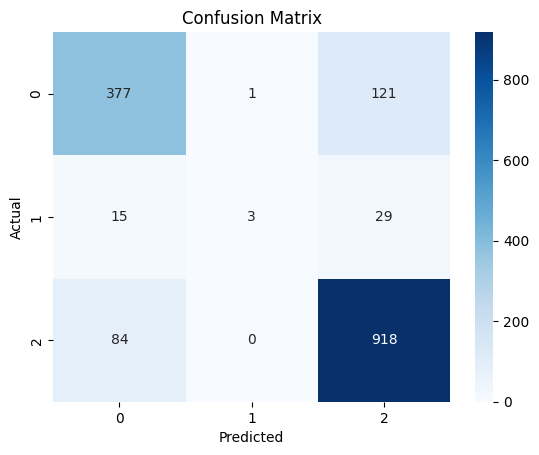

In [ ]:
# plot confusion matrix for best model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = best.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Comparison Between The Best Models

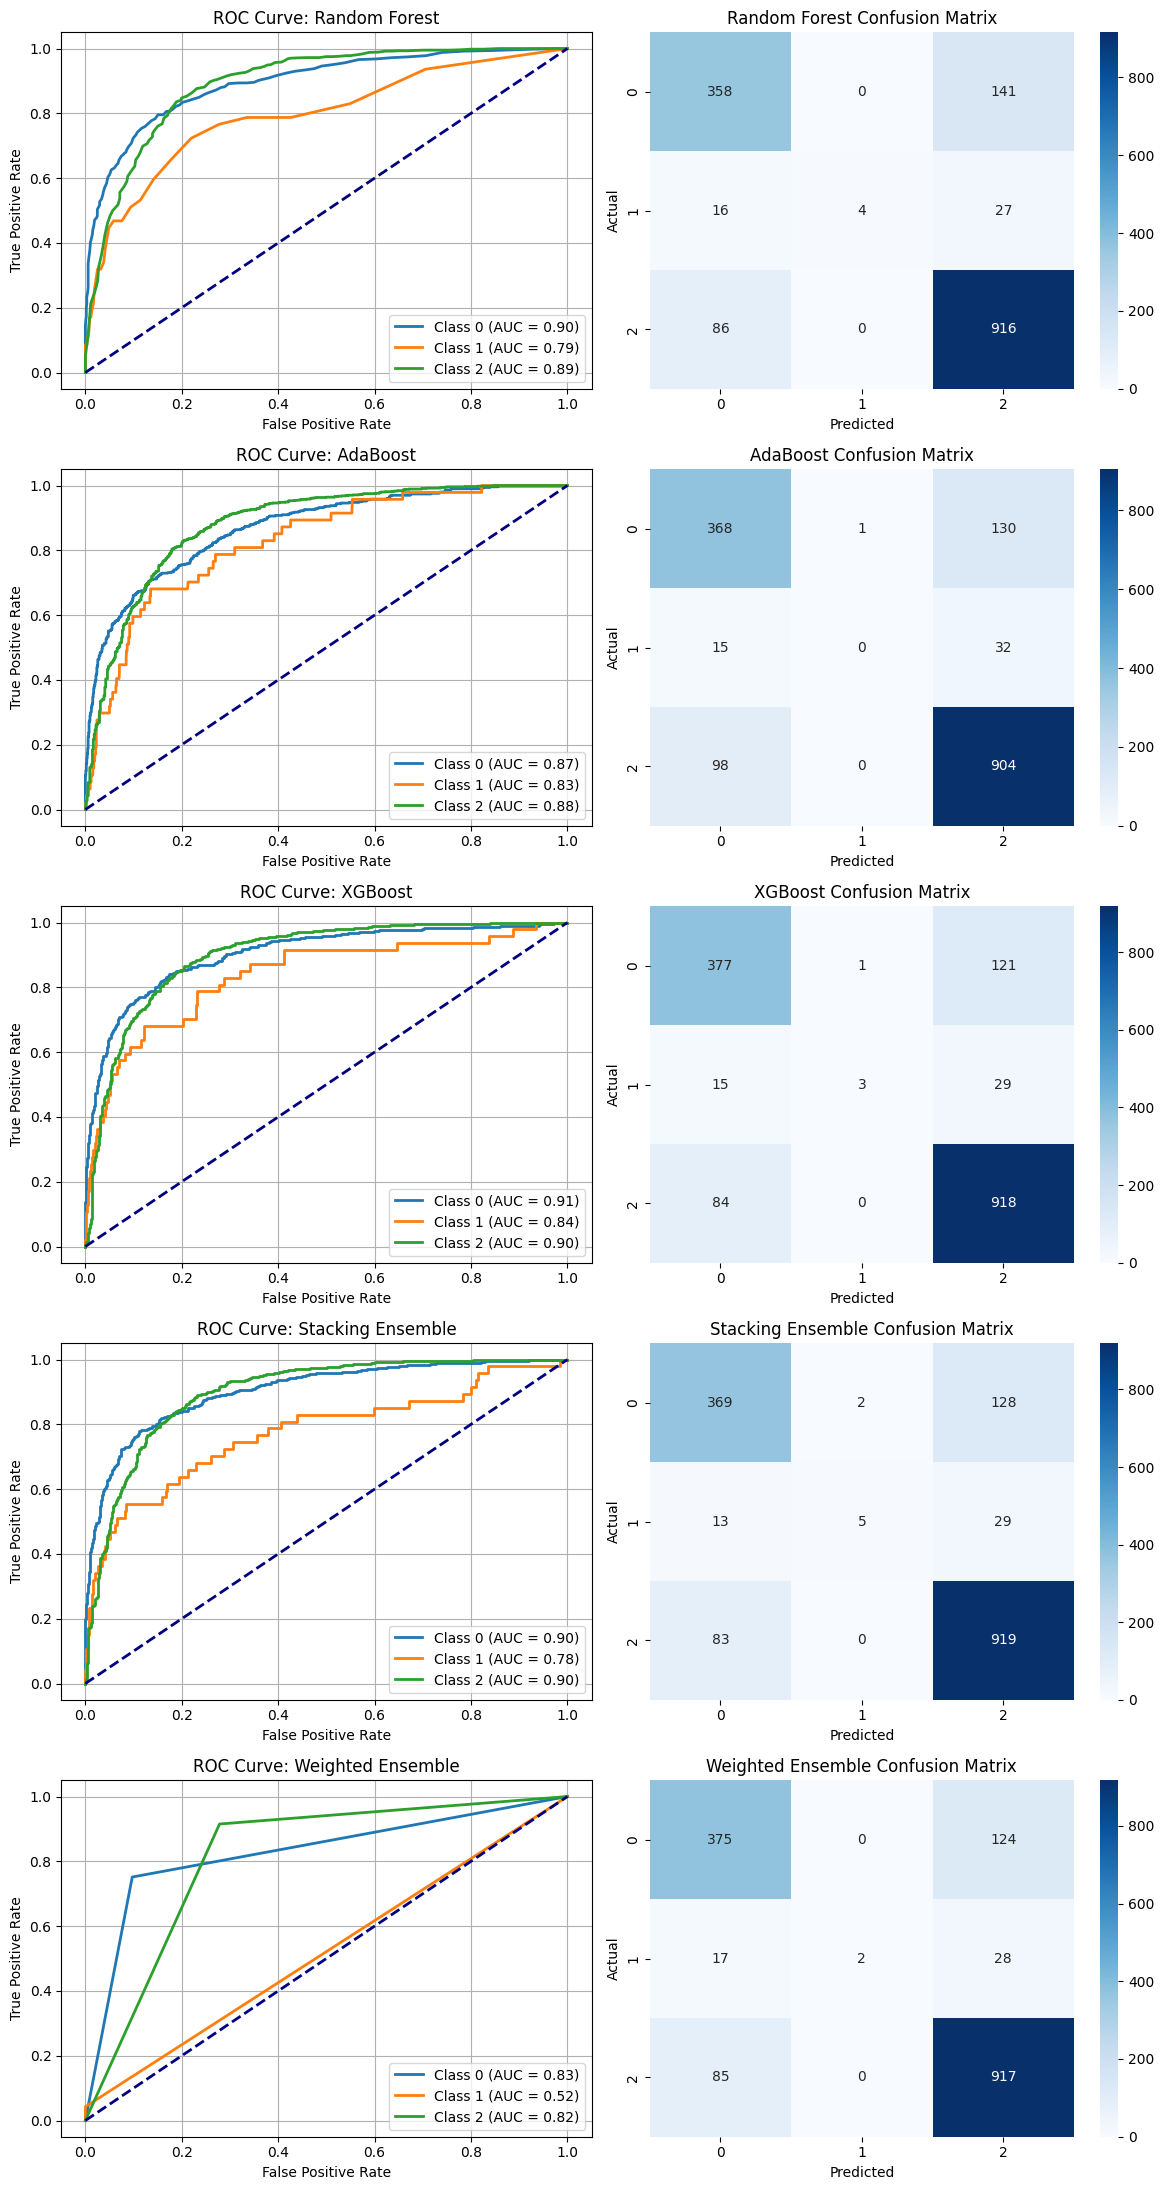

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize
import numpy as np

# Function to plot ROC curve (One-vs-All) for multi-class classification
def plot_roc_curve_ova(model, X_test, y_test, classes, label=None, ax=None):
    # Binarize the true labels for multi-class ROC calculation
    y_test_bin = label_binarize(y_test, classes=classes)
    n_classes = len(classes)

    # Plot ROC curve for each class against all others
    for i in range(n_classes):
        if hasattr(model, "predict_proba"):
            y_pred_prob = model.predict_proba(X_test)[:, i]  # Get predicted probabilities for class i
        elif hasattr(model, "decision_function"):
            y_pred_prob = model.decision_function(X_test)[:, i]  # Get decision scores if no probabilities
        else:
            # Fallback: predict class labels and convert to binary for ROC
            y_pred_prob = (model.predict(X_test) == classes[i]).astype(int)

        # Compute false positive rate, true positive rate and thresholds
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob)
        # Calculate area under the curve (AUC)
        roc_auc = auc(fpr, tpr)
        # Plot ROC curve for this class
        ax.plot(fpr, tpr, lw=2, label=f'Class {classes[i]} (AUC = {roc_auc:.2f})')

    # Plot diagonal line for random guessing baseline
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_title(f'ROC Curve: {label}')      # Title with model/ensemble name
    ax.set_xlabel('False Positive Rate')     # X-axis label
    ax.set_ylabel('True Positive Rate')      # Y-axis label
    ax.legend(loc='lower right')              # Legend with class names and AUC
    ax.grid(True)                             # Add grid for readability


# Function to plot confusion matrix heatmap
def plot_confusion_matrix(y_true, y_pred, classes, title, ax=None):
    cm = confusion_matrix(y_true, y_pred)    # Compute confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',  # Plot heatmap with counts
                xticklabels=classes, yticklabels=classes, ax=ax)
    ax.set_title(f'{title}')                  # Title of confusion matrix
    ax.set_xlabel('Predicted')                # X-axis label
    ax.set_ylabel('Actual')                   # Y-axis label


# Create a figure with 5 rows and 2 columns (ROC and Confusion Matrix side by side)
fig, axes = plt.subplots(5, 2, figsize=(12, 22))

classes = np.unique(y_test)  # Get unique class labels

# Loop through each model in best_models dictionary
for i, (name, model) in enumerate(best_models.items()):
    # Plot ROC curve in the left column
    plot_roc_curve_ova(model, X_test_scaled, y_test, classes, label=name, ax=axes[i, 0])

    # Predict test set labels for confusion matrix
    y_pred = model.predict(X_test_scaled)
    # Plot confusion matrix in the right column
    plot_confusion_matrix(y_test, y_pred, classes, title=f'{name} Confusion Matrix', ax=axes[i, 1])

# Plot ROC and confusion matrix for stacking ensemble in row 4
plot_roc_curve_ova(ensembles['stacking'], X_test_scaled, y_test, classes, label='Stacking Ensemble', ax=axes[3, 0])
stacking_preds = ensembles['stacking'].predict(X_test_scaled)
plot_confusion_matrix(y_test, stacking_preds, classes, title='Stacking Ensemble Confusion Matrix', ax=axes[3, 1])

# Plot ROC and confusion matrix for weighted ensemble in row 5
plot_roc_curve_ova(weighted_ensemble, X_test_scaled, y_test, classes, label='Weighted Ensemble', ax=axes[4, 0])
weighted_preds = weighted_ensemble.predict(X_test_scaled)
plot_confusion_matrix(y_test, weighted_preds, classes, title='Weighted Ensemble Confusion Matrix', ax=axes[4, 1])

plt.tight_layout()  # Adjust subplots to prevent overlap
plt.show()          # Display the complete figure


In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Prepare a list to store performance metrics
performance_data = []

for name, model in best_models.items():
    y_pred = model.predict(X_test_scaled)

    # For multiclass, average='weighted' handles class imbalance better
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    performance_data.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

# Also add stacking ensemble
name = 'Stacking Ensemble'
y_pred = ensembles['stacking'].predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
performance_data.append({
    'Model': name,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})

# Add weighted ensemble
name = 'Weighted Ensemble'
y_pred = weighted_ensemble.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
performance_data.append({
    'Model': name,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})

# Create DataFrame for performance summary
performance_df = pd.DataFrame(performance_data)
print(performance_df)


               Model  Accuracy  Precision    Recall  F1-Score
0      Random Forest  0.825581   0.828205  0.825581  0.813904
1           AdaBoost  0.821705   0.795541  0.821705  0.807999
2            XGBoost  0.838501   0.834455  0.838501  0.826972
3  Stacking Ensemble  0.835271   0.830329  0.835271  0.824930
4  Weighted Ensemble  0.835917   0.839032  0.835917  0.823400
